In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")
!ls "/content/gdrive/My Drive/Sigmoid"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/
kmnist_classmap.csv   kmnist-train-imgs.npy    Submission.csv
KMNIST.ipynb	      kmnist-train-labels.npy
kmnist-test-imgs.npy  models


In [2]:
%pylab inline
!pip install pycm livelossplot

from livelossplot import PlotLosses
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

Populating the interactive namespace from numpy and matplotlib
     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 491kB 8.0MB/s 
     |████████████████████████████████| 215kB 49.2MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.3 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
Cuda installed! Running on GPU!


In [0]:
path="/content/gdrive/My Drive/Sigmoid/"
train_data = np.load(path+"kmnist-train-imgs.npy")
test_data = np.load(path+"kmnist-test-imgs.npy")
train_labels = np.load(path+"kmnist-train-labels.npy")
classmap = pd.read_csv(path+"kmnist_classmap.csv")

In [4]:
print("Train Data:", train_data.shape)
print("Test Data:", test_data.shape)
print("Train Labels:", train_labels.shape)

Train Data: (60000, 28, 28)
Test Data: (10000, 28, 28)
Train Labels: (60000,)


In [0]:
# Tensor of training data
X = torch.from_numpy(train_data).float()
# Tensor of training labels
y = torch.from_numpy(train_labels).long()
#  Tensor of test data
X_test = torch.from_numpy(test_data).float()

In [0]:
class CustomTensorDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = sample.view(1, 28, 28).float()
        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [0]:
def normalise_image(data, mean, std):
  X_norm = data[:].float()
  X_norm = X_norm - mean
  X_norm = X_norm / std
  return X_norm

In [0]:
# Model and Optimiser selection

class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    # The implementation of the LeNet5 architecture
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.act = nn.ReLU()
    
  def forward(self, x):
    # Applying the ReLU activation function throughout the net
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)

In [0]:
class SupervisedLearning:
    def __init__(self, X, y, model, optimiser, loss_function, batch_size, test_batch_size,
                 device="cpu", 
                 confusion_matrix=True, 
                 train_transform=None,
                 val_transform=None, 
                 seed=42, n_epochs=30,
                 val_ratio=0.1, n_splits=1, 
                 early_stop = True,
                 patience = None,
                 tol = None):
      """
      
      """
      
      self.device = device
      
      self.X = X.float()/255.
      self.y = y
      
      self.model = model.to(self.device)
      self.optimiser = optimiser
      self.loss_function = loss_function
      
      self.X_train = None
      self.X_val = None
      
      self.y_train = None
      self.y_val = None
      
      self.train_transform = train_transform
      self.val_transform = val_transform
      
      assert(batch_size > 0 and batch_size < int(0.1 * X.size()[0]))
      self.batch_size = batch_size
      assert(test_batch_size > 0 and test_batch_size < int(0.1 * X.size()[0]))
      self.test_batch_size = test_batch_size
      self.n_epochs = n_epochs
      self.seed = seed
      self.val_ratio = val_ratio
      self.n_splits = n_splits

      self.trained_full=False
      
      self.mean_full = None
      self.std_full = None
      self.mean = None
      self.std = None
      
      self.logs = None # saves the liveloss object data
      
      self.best_model = None
      
      self.early_stop = early_stop
      if self.early_stop: self.early =  early_stopping(patience=patience, rel_tol=tol)  
      
      
    def split_data(self):
      sss = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.val_ratio, random_state=0)
      sss.get_n_splits(self.X, self.y)

      for train_index, val_index in sss.split(self.X, self.y):
        self.X_train, self.X_val = self.X[train_index], self.X[val_index]
        self.y_train, self.y_val = self.y[train_index], self.y[val_index]
        
      return None
      
      
      
    def train(self, train_data_loader):
      self.model.train()                # set model to train mode
      
      train_loss, train_accuracy = 0., 0.
      
      for Xtr, ytr in train_data_loader:# X and y are data inside a batch specified
                                        # at train_data_loader
        Xtr = Xtr.to(self.device)
        ytr = ytr.to(self.device)
        
        optimiser.zero_grad()           # reset gradients
        zn = model(Xtr)                 # perform forward pass
        
        loss = loss_function(zn, ytr)   # compute loss value over batch
        loss.backward()                 # perform backward pass
        train_loss += (loss * Xtr.size()[0]).detach().cpu().numpy()
        

        y_pred = F.log_softmax(zn, dim=1).max(1)[1]
        train_accuracy += accuracy_score(ytr.cpu().numpy(), y_pred.detach().cpu().numpy())*Xtr.size()[0]
        
        optimiser.step()               # optimisation step
        
      return train_loss/len(train_data_loader.dataset), train_accuracy/len(train_data_loader.dataset)
    
    
    
    def validate(self, val_data_loader):
      self.model.eval()                     # set model to evaluation mode
      
      validation_loss, validation_accuracy = 0., 0.
      
      for Xv, yv in val_data_loader:
        with torch.no_grad():
          
          Xv, yv = Xv.to(self.device), yv.to(self.device)
          
          zn = model(Xv)
          loss = loss_function(zn, yv)
          validation_loss += (loss * Xv.size(0)).detach().cpu().numpy()
          
          y_pred = F.log_softmax(zn, dim=1).max(1)[1]
          validation_accuracy += accuracy_score(yv.cpu().numpy(), y_pred.detach().cpu().numpy())*Xv.size(0)

            
      return validation_loss/len(val_data_loader.dataset), validation_accuracy/len(val_data_loader.dataset)
        
      
    
    def train_wrapper(self, train_full=False, plot_loss=True):
      # set seed
      set_seed(int(self.seed))
      
      
      if train_full: # train with full data (train + validation)
        # find mean and std of training data
        mean, std = self.find_mean_std(train_full)
        
        # create dataloaders
        train_dataset = CustomTensorDataset(normalise_image(self.X, mean, std), self.y, transform=self.train_transform)
        train_data_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        best_train_acc = 0
        
        # train and validate
        if plot_loss: liveloss = PlotLosses()
        for epoch in range(self.n_epochs):
            logs = {}
            train_loss, train_accuracy = self.train(train_data_loader)

            if plot_loss:
              logs['' + 'log loss'] = train_loss.item()
              logs['' + 'accuracy'] = train_accuracy.item()
              logs['val_' + 'log loss'] = 1.
              logs['val_' + 'accuracy'] = 1.
              liveloss.update(logs)
              liveloss.draw()
              
            # Checking stopping criteria
            if self.early_stop: self.early(train_accuracy)
                
            # Saving the best weights    
            if train_accuracy.item() > best_train_acc:  
              # Saving the models weights to best model
              self.best_model = self.model
              best_train_acc = train_accuracy.item()
            
            # If the stopping criteria is met  
            if self.early.stop: 
                self.model = self.best_model
                break
                
        self.trained_full=True
        self.logs = liveloss

      else:
        # split data
        self.split_data()
        
        # find mean and std of training data
        mean, std = self.find_mean_std(train_full)
        
        
        # create dataloaders

        train_dataset = CustomTensorDataset(normalise_image(self.X_train, mean, std), self.y_train, transform=self.train_transform)
        train_data_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        
        val_dataset = CustomTensorDataset(normalise_image(self.X_val, mean, std), self.y_val, transform=self.val_transform)
        val_data_loader = DataLoader(val_dataset, batch_size=self.test_batch_size, shuffle=False)
        
        best_val_acc = 0
            
        # train and validate
        if plot_loss: liveloss = PlotLosses()
        for epoch in range(self.n_epochs):
            logs = {}
            train_loss, train_accuracy = self.train(train_data_loader)
            val_loss, val_accuracy = self.validate(val_data_loader)
            
            if plot_loss:
              logs['' + 'log loss'] = train_loss.item()
              logs['' + 'accuracy'] = train_accuracy.item()
              logs['val_' + 'log loss'] = val_loss.item()
              logs['val_' + 'accuracy'] = val_accuracy.item() # liveloss wants it plotted
              liveloss.update(logs)
              liveloss.draw() 
            
            # Checking stopping criteria
            if self.early_stop: self.early(val_accuracy)
                
            # Saving the best weights    
            if val_accuracy.item() > best_val_acc:  
              self.best_model = self.model
              best_val_acc = val_accuracy.item()
            
            # If the stopping criteria is met  
            if self.early.stop: 
                self.model = self.best_model
                break

        self.logs = logs
        self.trained_full=False
        self.model = self.best_model
              
      return None
            
            
    def evaluate_batch(self, X_test, y_test, confusion_matrix=True, test_transform=None):
      """
      This method performs the same as validate but also returns all predictions on a given dataset
      for a trained model.
      """
      self.model.eval()
      
      mean, std = self.find_mean_std(True)
      
      test_dataset = CustomTensorDataset(normalise_image(X_test, mean, std), y_test, transform=test_transform)
      test_data_loader = DataLoader(test_dataset, batch_size=self.test_batch_size, shuffle=True)
      
      ys, y_preds = [], []
      for X, y in test_data_loader:
          with torch.no_grad():
              X, y = X.to(self.device), y.to(self.device)
              a2 = self.model(X)
              y_pred = F.log_softmax(a2, dim=1).max(1)[1]
              ys.append(y.cpu().numpy())
              y_preds.append(y_pred.cpu().numpy())
            
      y_preds, ys =  np.concatenate(y_preds, 0),  np.concatenate(ys, 0)
      
      test_loss, test_accuracy = self.validate(test_data_loader)
      
      if confusion_matrix:
        cm = ConfusionMatrix(actual_vector=ys, predict_vector=y_preds)
        print(cm)
        
        
      return y_preds, ys, test_loss, test_accuracy
    
    
    def get_hyperparameters(self):
      """
      Returns a dictiorary with the follwing hyperparameters:
      
      """
      
      return None
    
    
    def find_mean_std(self, full_training=False):
      """
      Finds the mean and std values of a normalised image (divided by 255)
      """
      mean = 0
      std = 0
      
      if full_training:
        mean = torch.mean(self.X)
        std = torch.std(self.X)
        
        self.mean_full = mean
        self.std_full = std
        
      else:
        mean = torch.mean(self.X_train)
        std = torch.std(self.X_train)
        self.mean = mean
        self.std = std
        
      return mean, std

In [0]:
class early_stopping:
  """
  Counter to implement early stopping
  If validation accuracy has not relative improved above
  a absolute tolerance set by the user than it breaks the 
  training
  If rel_tol is set to 0 it becomes a common counter
  """
  def __init__(self, patience, rel_tol, verbose=True):

    
    self.patience = patience
    self.rel_tol = rel_tol
    self.verbose = verbose
    self.best_score = 0
    self.counter = 0
    self.stop = False

  
  def __call__(self, score):
    
    # If the score is under the required relative tolerance
    # increase the counter is incremented
    if score < self.best_score * (1 + self.rel_tol):
        self.counter += 1
    else:
        self.counter = 0
        
    if score > self.best_score:
      self.best_score = score

      
    if self.counter >= self.patience:
      self.stop = True    
      
    if self.verbose:
      print("Count:", self.counter)

In [0]:
def model_save(model, name, path, val_score):
  """Saving function to keep track of models"""
  val = str(val_score)[2:5]
  path = path + name + '_' + val + '.pth'
  print(path)
  torch.save(model, path)
  return


def model_load(path, model_name):
  """Loading function for models from google drive"""
  print(path + model_name + '.pth')
  model = torch.load(path + model_name + '.pth')
  return model

In [0]:
# Hyperparameters
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30

model = LeNet5()
optimiser = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
loss_function = nn.CrossEntropyLoss()

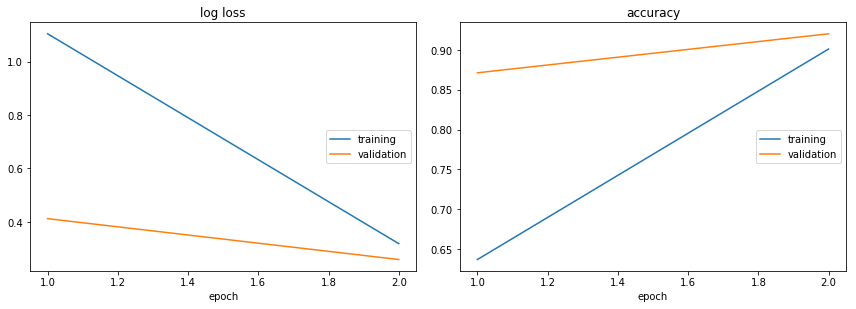

log loss:
training   (min:    0.319, max:    1.104, cur:    0.319)
validation (min:    0.259, max:    0.412, cur:    0.259)

accuracy:
training   (min:    0.637, max:    0.901, cur:    0.901)
validation (min:    0.871, max:    0.920, cur:    0.920)
Count: 0


In [14]:
learning = SupervisedLearning(X, y, model, optimiser, loss_function, batch_size, test_batch_size,
                 device="cpu", 
                 confusion_matrix=True, 
                 train_transform=None,
                 val_transform=None, 
                 seed=42, n_epochs=2,
                 val_ratio=0.1, n_splits=1, 
                 early_stop = True,
                 patience = 5,
                 tol = 0.001)

learning.train_wrapper(train_full=False)

In [0]:
 def evaluate_test(X_test, model, norm_mean, norm_std, test_batch_size=30, test_transform=None, device="cpu", save_to_csv=False, path="/content/gdrive/My Drive/foo.csv"):
      """
      This method takes a tensor of images and a trained model and returns the predicted labels
      from those images
      Params
      ------
        X_test: torch.tensor of size (no_images, 28, 28), test images dataset
        model: nn.Module or inherited class object
        test_batch_size: int, defines the size of the batch for the datset
        test_transform: transforms.Compose list of transforms to apply to the dataset
        device: str, on which device to run the model
        save_to_csv: bool, option to save predictions to csv in format (index, prediction)
        path: str, path to save string 
        
      Returns
      -------
        y_preds: np.array of predictios made on X_test by the trained model
        
      """
      model.eval()
      model.to(device)
      y_test = torch.zeros_like(X_test)
      test_dataset = CustomTensorDataset(normalise_image(X_test/255., norm_mean, norm_std), y_test, transform=test_transform)
      test_data_loader = DataLoader(test_dataset, test_batch_size, shuffle=False)
      
      y_preds = []
      for X, y in test_data_loader:
          with torch.no_grad():
              X, y = X.to(device), y.to(device)
              a2 = model(X)
              y_pred = F.log_softmax(a2, dim=1).max(1)[1]
              y_preds.append(y_pred.cpu().numpy())
            
      y_preds =  np.concatenate(y_preds, 0)
      sub = pd.DataFrame(data={'Category': y_preds})
      
      sub.index.name = "Id" 
      
      if save_to_csv: sub.to_csv(path)

      return y_preds, sub

In [0]:
y_preds, df = evaluate_test(X_test, learning.model, learning.mean, learning.std, save_to_csv=True, path="/content/gdrive/My Drive/Sigmoid/Submission.csv")

In [77]:
# Examples of save and load functionality
model_save(learning.model, "lenet5", path + "Models/", learning.logs["val_accuracy"])
model_1 = model_load(path + "Models/", model_name="lenet5_920" )

/content/gdrive/My Drive/Sigmoid/Models/lenet5_920.pth
/content/gdrive/My Drive/Sigmoid/Models/lenet5_920.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LeNet5. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
class ensemble_net(nn.Module):
    def __init__(self, modelA, modelB):
        super(ensemble_net, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(4, 2)
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(F.relu(x))
        return x

In [81]:
model_1 = model_load(path + "Models/", model_name="lenet5_920" ).state_dict()
model_2 = model_load(path + "Models/", model_name="lenet5_920" ).state_dict()

model = ensemble_net(model_1, model_2)

/content/gdrive/My Drive/Sigmoid/Models/lenet5_920.pth
/content/gdrive/My Drive/Sigmoid/Models/lenet5_920.pth


In [0]:
print(classmap)

for i in range(10):
  print(y_preds[i], classmap["char"].iloc[y_preds[i]])

   index codepoint char
0      0    U+304A    お
1      1    U+304D    き
2      2    U+3059    す
3      3    U+3064    つ
4      4    U+306A    な
5      5    U+306F    は
6      6    U+307E    ま
7      7    U+3084    や
8      8    U+308C    れ
9      9    U+3092    を
2 す
9 を
3 つ
8 れ
3 つ
3 つ
8 れ
3 つ
6 ま
5 は


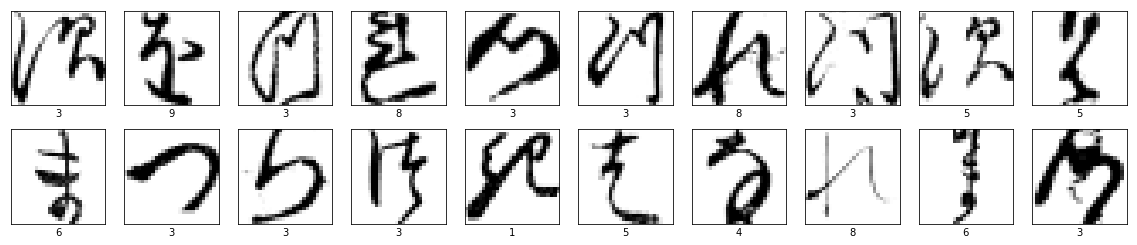

In [0]:
plt.figure(figsize=(20,4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    plt.xlabel(y_preds[i])

In [0]:
# Saving the model to my google drive
# model_save_name = 'LeNET' + learning.logs["val_accuracy"] + '.pt'
# path = F"/content/gdrive/My Drive/{model_save_name}" 
# torch.save(model.state_dict(), path)